## Census Income Project
Problem Statement:


This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight)
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.



In [1]:
#import necessary libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [82]:
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler

from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from scipy.stats import zscore

In [3]:
#reading the data
df = pd.read_csv('census_income.csv')
df

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
#checking the number of rows and columns of data
df.shape

(32560, 15)

In [5]:
#getting the overview and statistical analysis of data
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
#checking the different datatype of the attributes
df.info()

#getting the names of all columns
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [7]:
#getting the missing values and numll values present in the data
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [8]:
for i in df.columns:
    print(df[i].value_counts())
    print('*'*50)

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
86      1
87      1
Name: Age, Length: 73, dtype: int64
**************************************************
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
**************************************************
203488    13
123011    13
164190    13
121124    12
148995    12
          ..
218551     1
201204     1
362999     1
162297     1
145522     1
Name: Fnlwgt, Length: 21647, dtype: int64
**************************************************
 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th         

## Observations:
1. There are no null values in the dataset but there are zero values in the columns 
2. Age column has some outliers.
3. There are 1836 unknown value "?" in the Workclass column.
4. There are 1843 unknown values in Occupation column.
5. Capital Gain, Capital loss has nearly 95% values as 0.
6. Native_country has  583 unknown values.

In [9]:
df[df['Capital_loss']==0].index.value_counts()

0        1
2676     1
15026    1
8881     1
10928    1
        ..
19715    1
17666    1
23809    1
21760    1
4094     1
Length: 31041, dtype: int64

In [10]:
df[df['Capital_gain']==0].index.value_counts()

0        1
8913     1
17117    1
19164    1
29403    1
        ..
21824    1
11567    1
9518     1
15661    1
2047     1
Length: 29849, dtype: int64

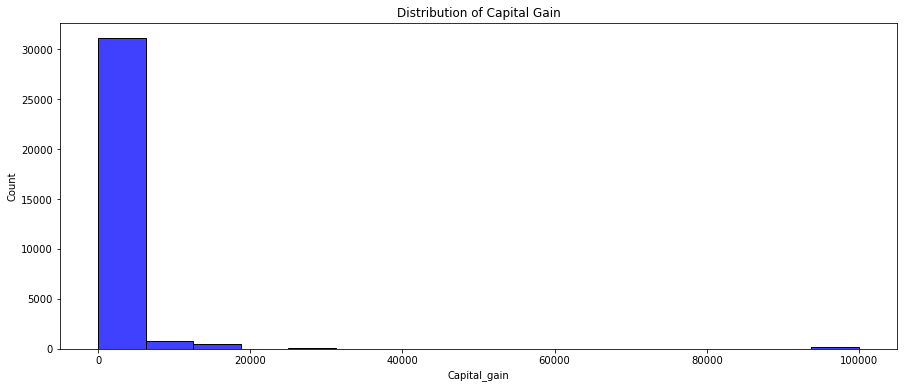

In [11]:
plt.figure(figsize=(15,6))
sns.histplot(df['Capital_gain'],color='blue')
plt.title('Distribution of Capital Gain')
plt.show()

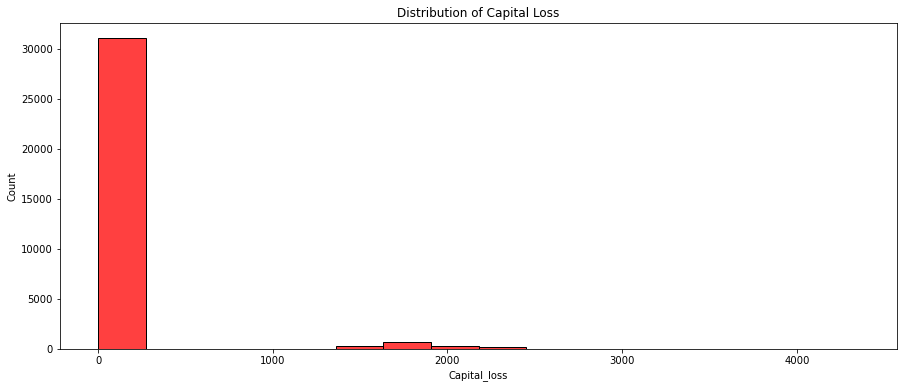

In [12]:
plt.figure(figsize=(15,6))
sns.histplot(df['Capital_loss'],color='red')
plt.title('Distribution of Capital Loss')
plt.show()

The Capital Gain and Capital Loss attributes have more number of zero values

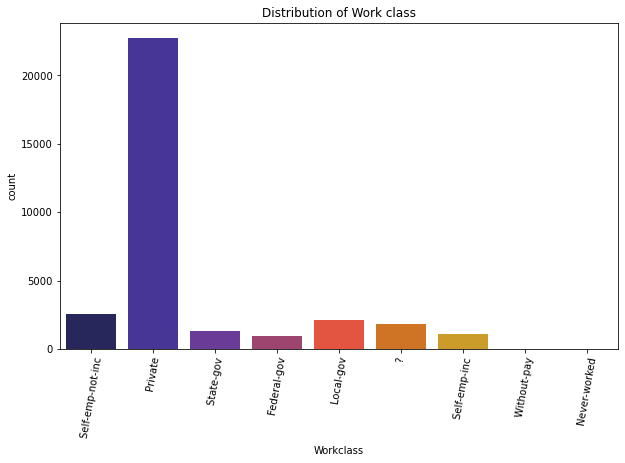

In [13]:
plt.figure(figsize=(10,6))
sns.countplot(x='Workclass', data=df, palette='CMRmap')
plt.xticks(rotation=80)
plt.title('Distribution of Work class')
plt.show()

Number of private employee is highest compared to all other class.

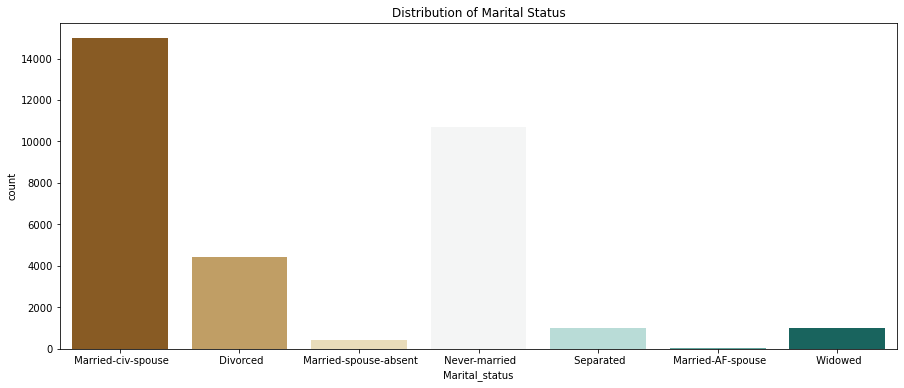

In [14]:
plt.figure(figsize=(15,6))
sns.countplot(x='Marital_status', data=df,palette='BrBG')
plt.title('Distribution of Marital Status')
plt.show()

Married civ spouse and Never married class has highest weightage in the dataset.

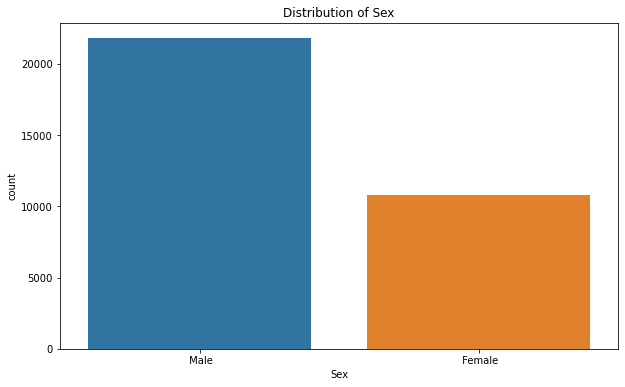

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(x='Sex', data=df)
plt.title('Distribution of Sex')
plt.show()

The ratio of male to female is nearly 50 % when compared in the dataset

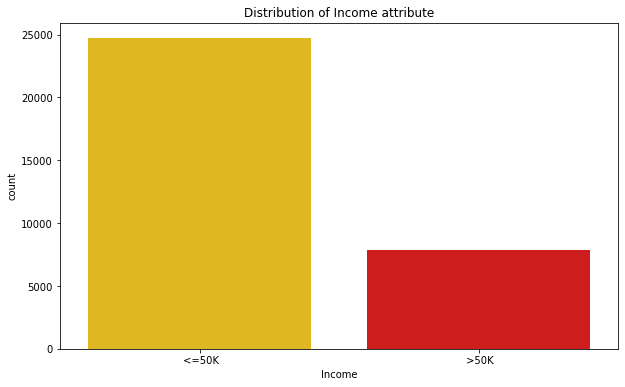

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(x='Income', data=df,palette='hot_r')
plt.title('Distribution of Income attribute')
plt.show()

The ratio of income "<=50k' and "">50k" is not equal, that is the data set is unbalanced, we need to treat this unbalanced datasets during preprocessing. 

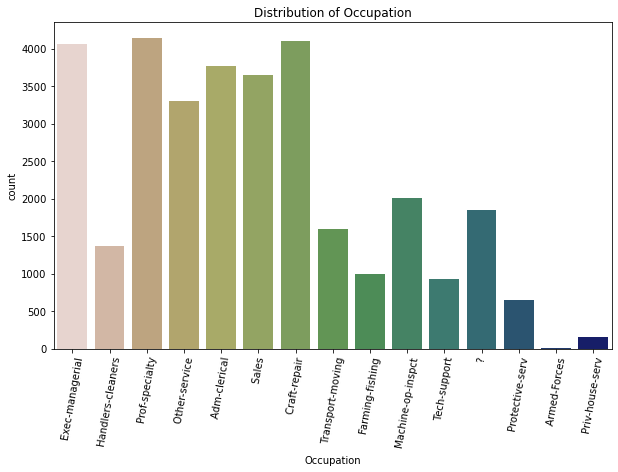

In [17]:
plt.figure(figsize=(10,6))
sns.countplot(x='Occupation', data=df,palette='gist_earth_r')
plt.xticks(rotation=80)
plt.title('Distribution of Occupation')
plt.show()

The variation of class of workers in ex-managerial, prof-speciality, craft repair, sales, adm-clerical are nearly equal, But the number of armed forces is the least of the class

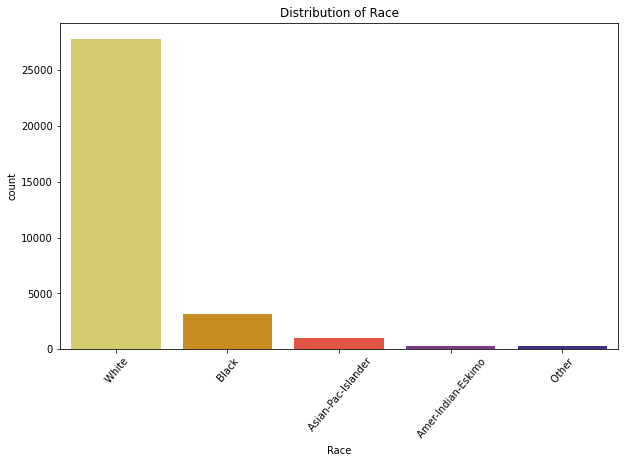

In [18]:
plt.figure(figsize=(10,6))
sns.countplot(x='Race', data=df, palette='CMRmap_r')
plt.xticks(rotation=50)
plt.title('Distribution of Race')
plt.show()

As the population in US, is highest with whites, there is high number seen in the datasets

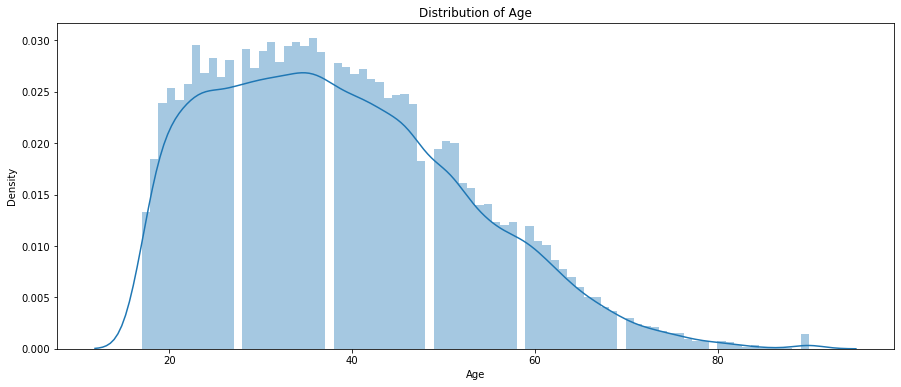

In [19]:
plt.figure(figsize=(15,6))
sns.distplot(df['Age'], kde=True, bins=80)
plt.title('Distribution of Age')
plt.show()

The age column is having small amount of left skewness, with age distributed around the mean of 30

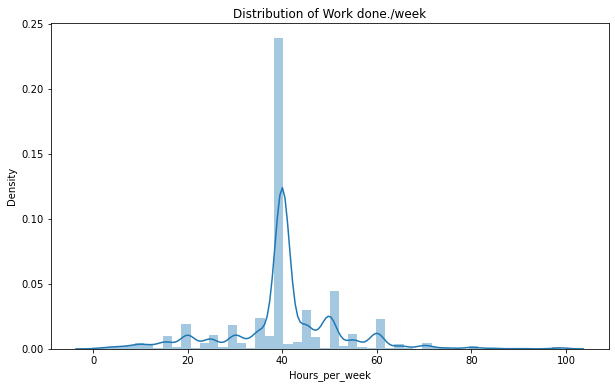

In [20]:
plt.figure(figsize=(10,6))
sns.distplot(df['Hours_per_week'])
plt.title('Distribution of Work done./week')
plt.show()

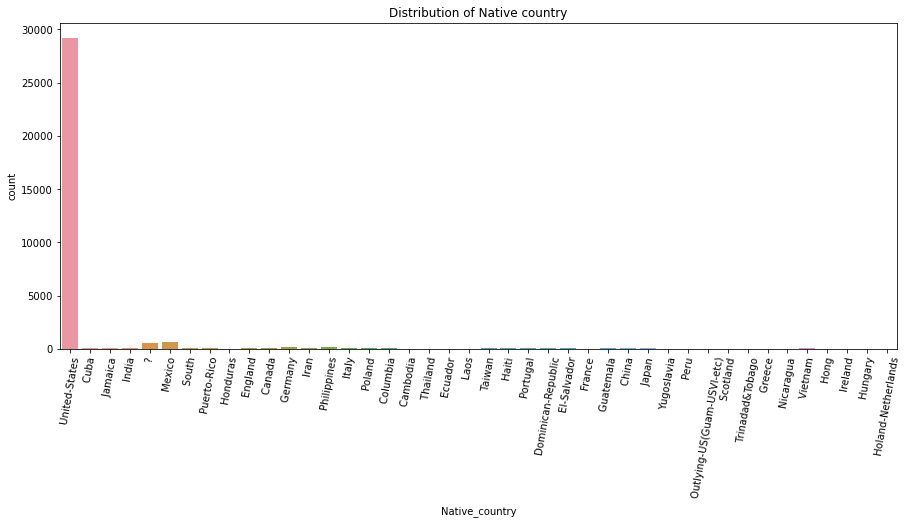

In [21]:
plt.figure(figsize=(15,6))
sns.countplot(df['Native_country'])
plt.xticks(rotation=80)
plt.title('Distribution of Native country')
plt.show()

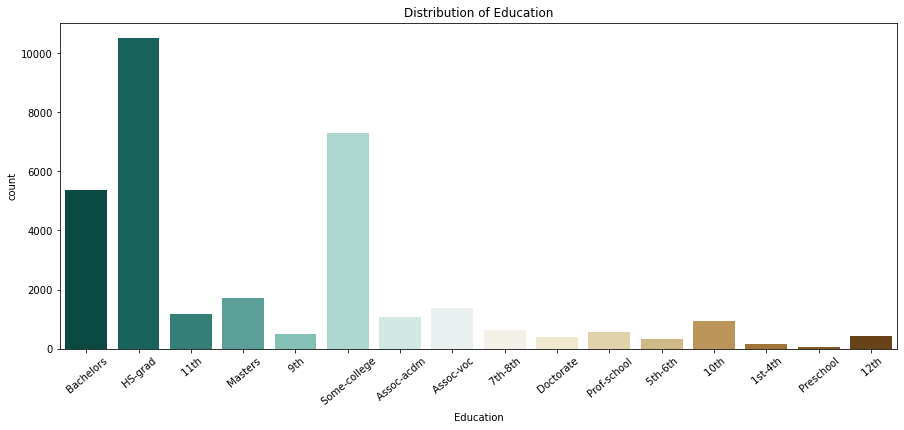

In [22]:
plt.figure(figsize=(15,6))
sns.countplot(df['Education'], palette='BrBG_r')
plt.xticks(rotation=40)
plt.title('Distribution of Education')
plt.show()

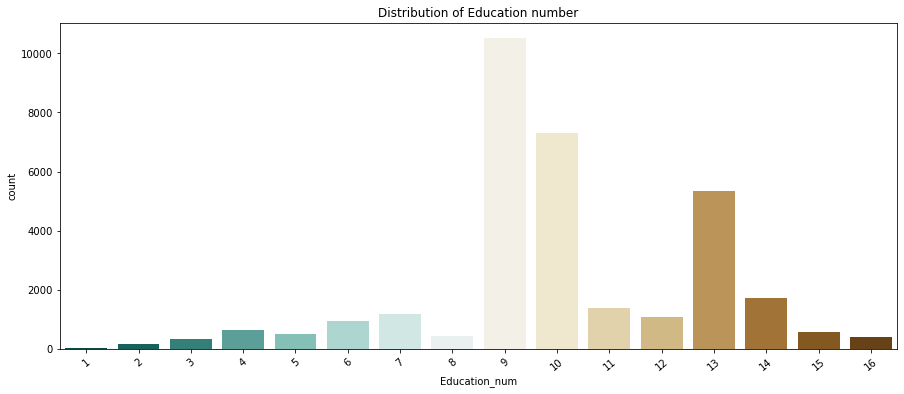

In [23]:
plt.figure(figsize=(15,6))
sns.countplot(df['Education_num'], palette='BrBG_r')
plt.xticks(rotation=40)
plt.title('Distribution of Education number')
plt.show()

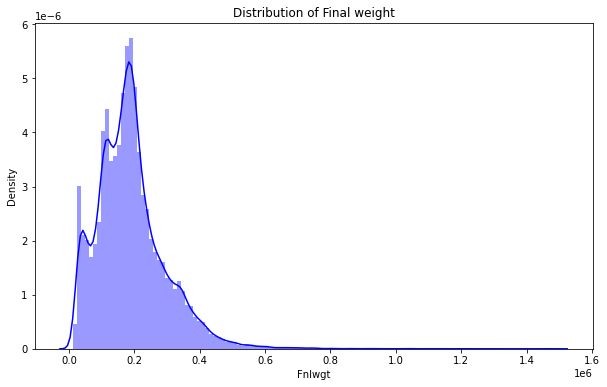

In [24]:
plt.figure(figsize=(10,6))
sns.distplot(df['Fnlwgt'], color='blue', bins=120)
plt.title('Distribution of Final weight')
plt.show()

There is skewness and some outliers present in the Fnlwgt attribute, it need to be treaded.

## Bi-Variate Analysis

### Taking "Sex" as hue.

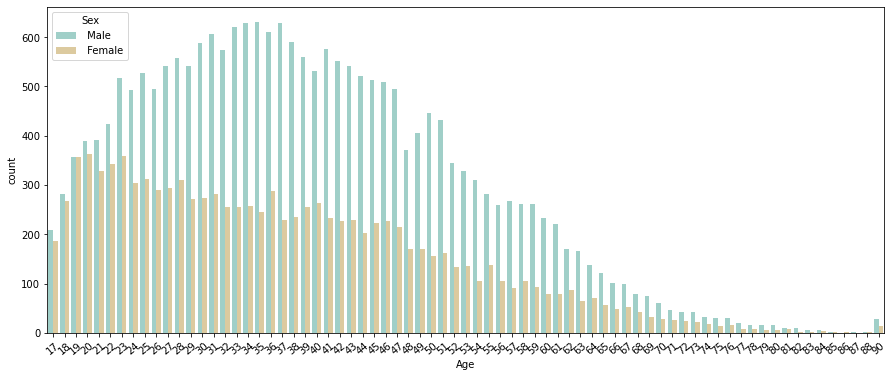

In [25]:
plt.figure(figsize=(15,6))
sns.countplot(x='Age', hue='Sex',data=df, palette='BrBG_r')
plt.xticks(rotation=40) 
plt.show()

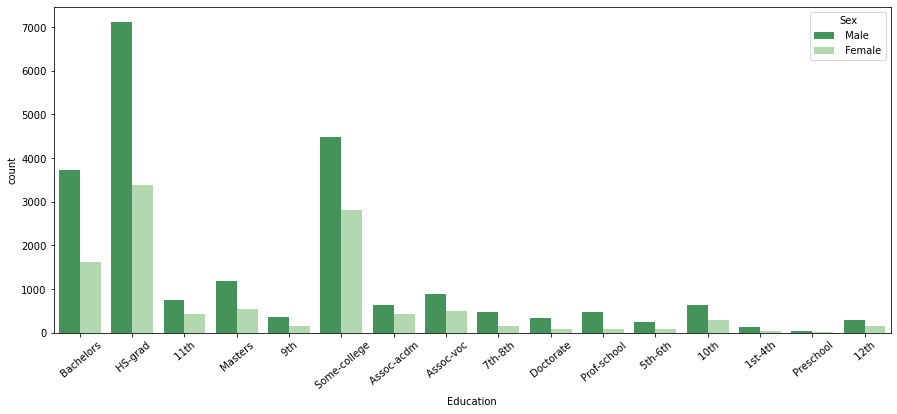

In [26]:
plt.figure(figsize=(15,6))
sns.countplot(x='Education', hue='Sex',data=df, palette='Greens_r')
plt.xticks(rotation=40) 
plt.show()

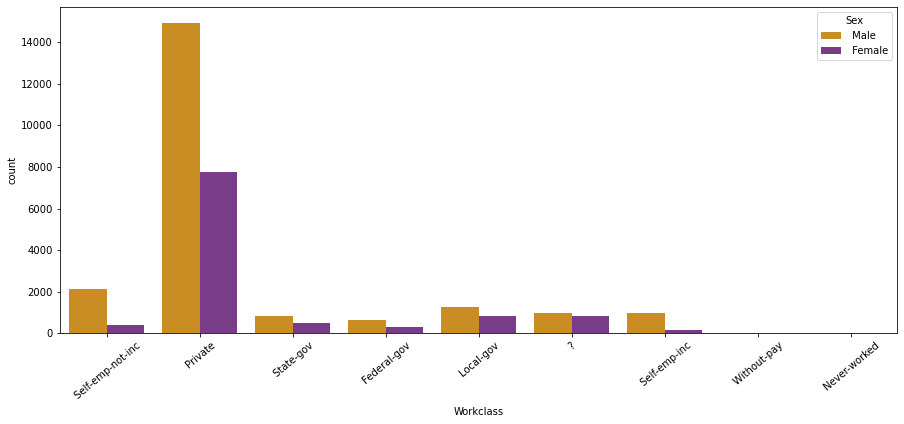

In [27]:
plt.figure(figsize=(15,6))
sns.countplot(x='Workclass', hue='Sex',data=df, palette='CMRmap_r')
plt.xticks(rotation=40)
plt.show()

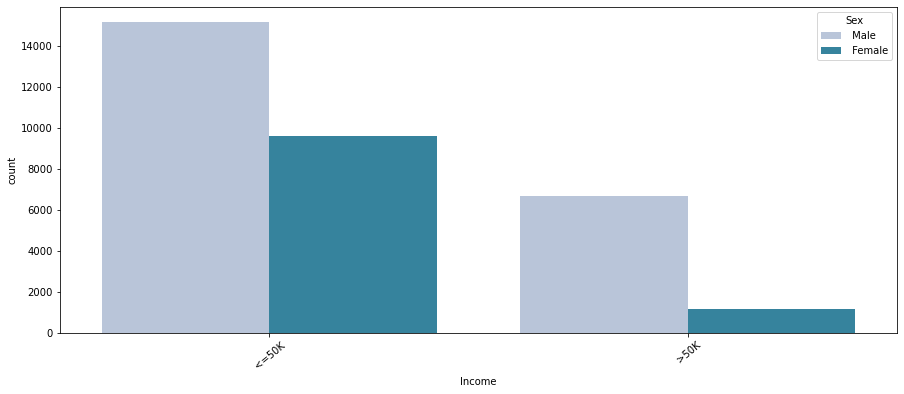

In [28]:
plt.figure(figsize=(15,6))
sns.countplot(x='Income', hue='Sex',data=df, palette='PuBuGn')
plt.xticks(rotation=40) 
plt.show()

### Observations:

#### There are nearly 50% more number of men than women, who are age of range 25-50.
#### In each class of Education, Work attribute, the % of male is higher than female, one of the reason for this may be due to the total number of women is less.


### Taking "income" as hue.

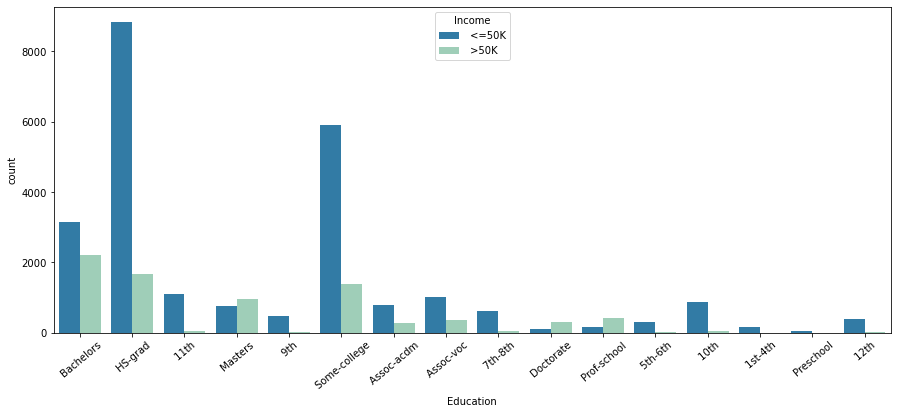

In [29]:
plt.figure(figsize=(15,6))
sns.countplot(x='Education', hue='Income',data=df, palette='YlGnBu_r')
plt.xticks(rotation=40) 
plt.show()

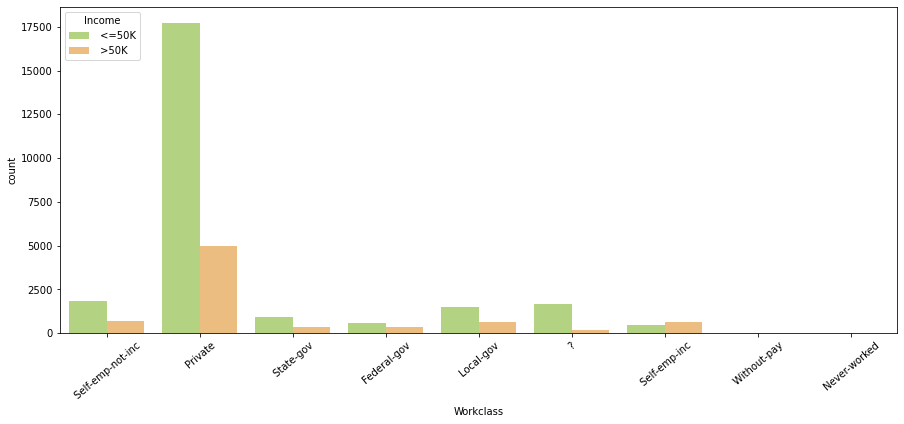

In [30]:
plt.figure(figsize=(15,6))
sns.countplot(x='Workclass', hue='Income',data=df, palette='RdYlGn_r')
plt.xticks(rotation=40) 
plt.show()

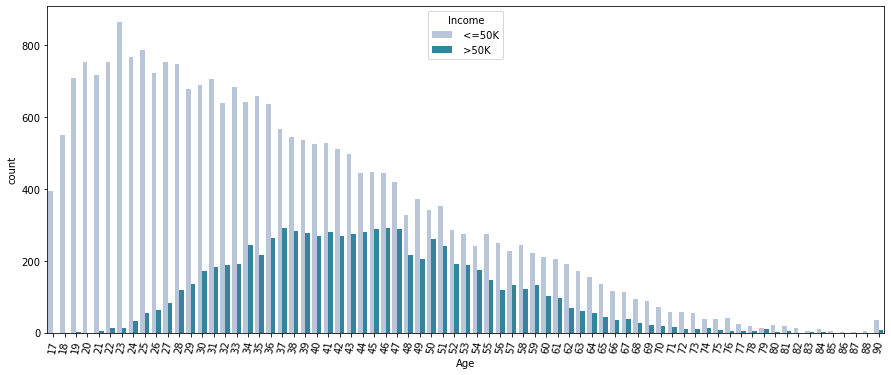

In [31]:
plt.figure(figsize=(15,6))
sns.countplot(x='Age', hue='Income',data=df, palette='PuBuGn')
plt.xticks(rotation=80) 
plt.show()

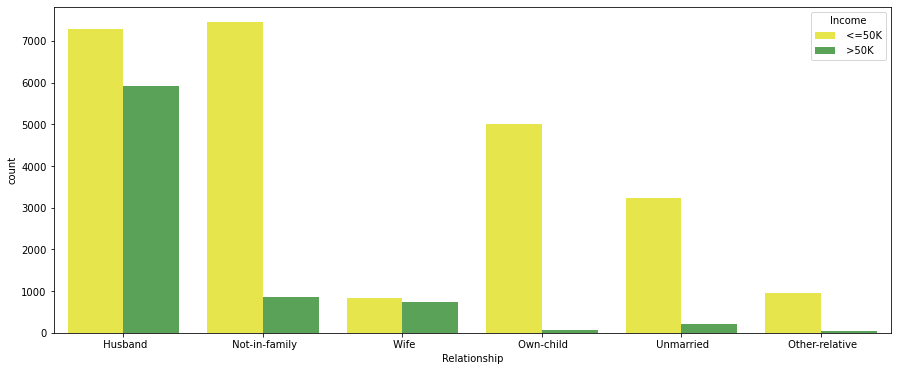

In [32]:
plt.figure(figsize=(15,6))
sns.countplot(x='Relationship', hue='Income',data=df, palette='Set1_r') 
plt.show()

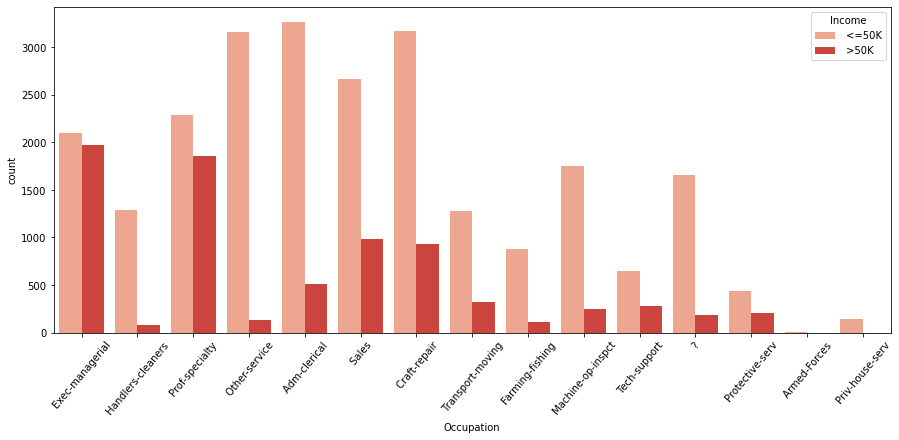

In [33]:
plt.figure(figsize=(15,6))
sns.countplot(x='Occupation', hue='Income',data=df, palette='Reds')
plt.xticks(rotation=50) 
plt.show()

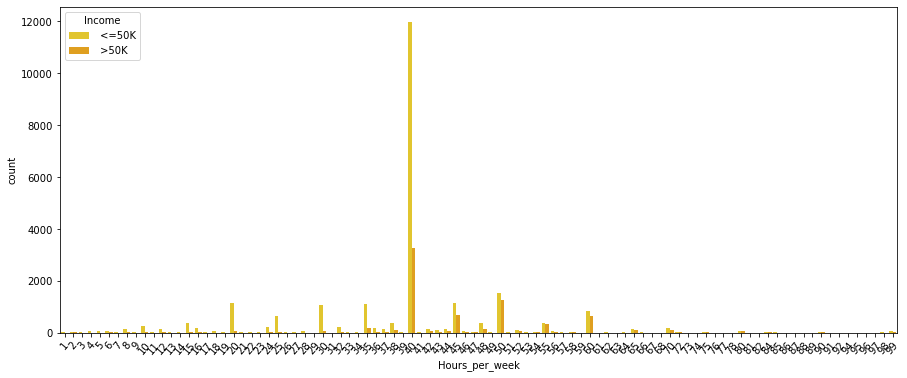

In [34]:
plt.figure(figsize=(15,6))
sns.countplot(x='Hours_per_week', hue='Income',data=df, palette='Wistia')
plt.xticks(rotation=50) 

plt.show()

## Observations:

#### The people of average age 25 to 60 are likely to have >50K income, But the average income is less than 50K in all the attributes, 
#### Ex-managerial is nearly having equal ratios of income having >50k and <50k.
#### The Only attribute in Workclass to have higher percentage of '>50K' is self_empl_inc. 

## Multivariate Analysis

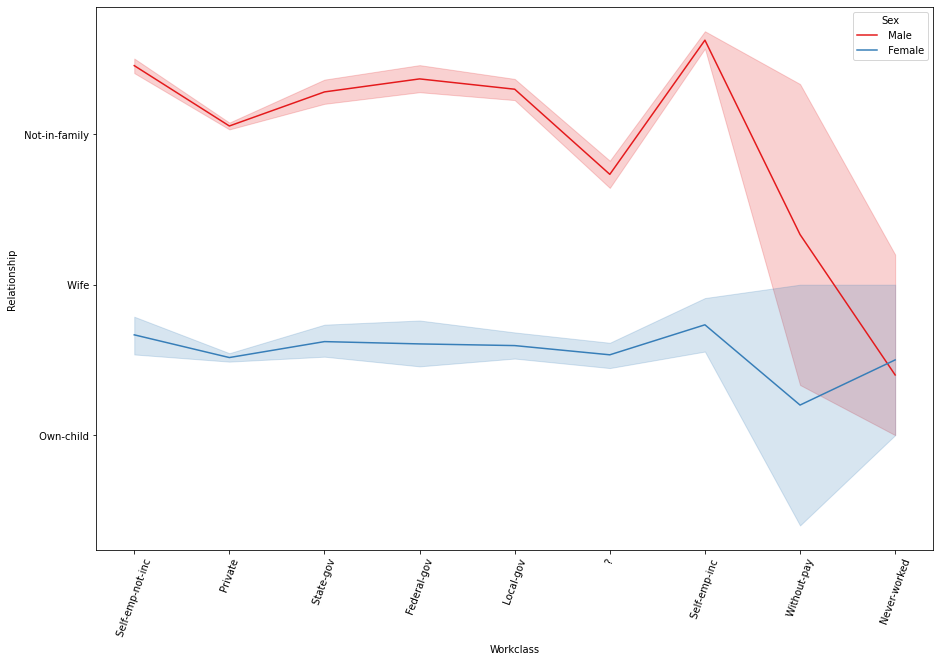

In [35]:
plt.figure(figsize=(15,10))
sns.lineplot(x='Workclass', y='Relationship', hue='Sex',data=df, palette='Set1')
plt.xticks(rotation=70) 
plt.show()

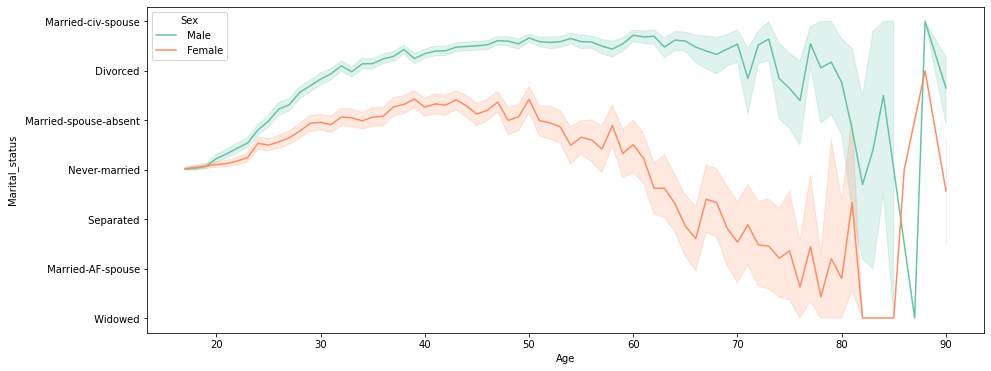

In [36]:
plt.figure(figsize=(15,6))
sns.lineplot(x='Age', y='Marital_status', hue='Sex',data=df, palette='Set2')
plt.xticks(rotation=0) 
plt.show()

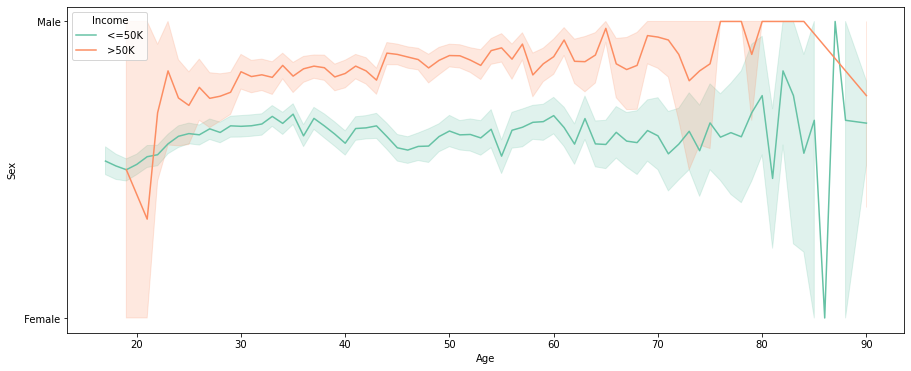

In [37]:
plt.figure(figsize=(15,6))
sns.lineplot(x='Age', hue='Income', y='Sex',data=df, palette='Set2')
plt.xticks(rotation=0) 
plt.show()

<Figure size 1080x1080 with 0 Axes>

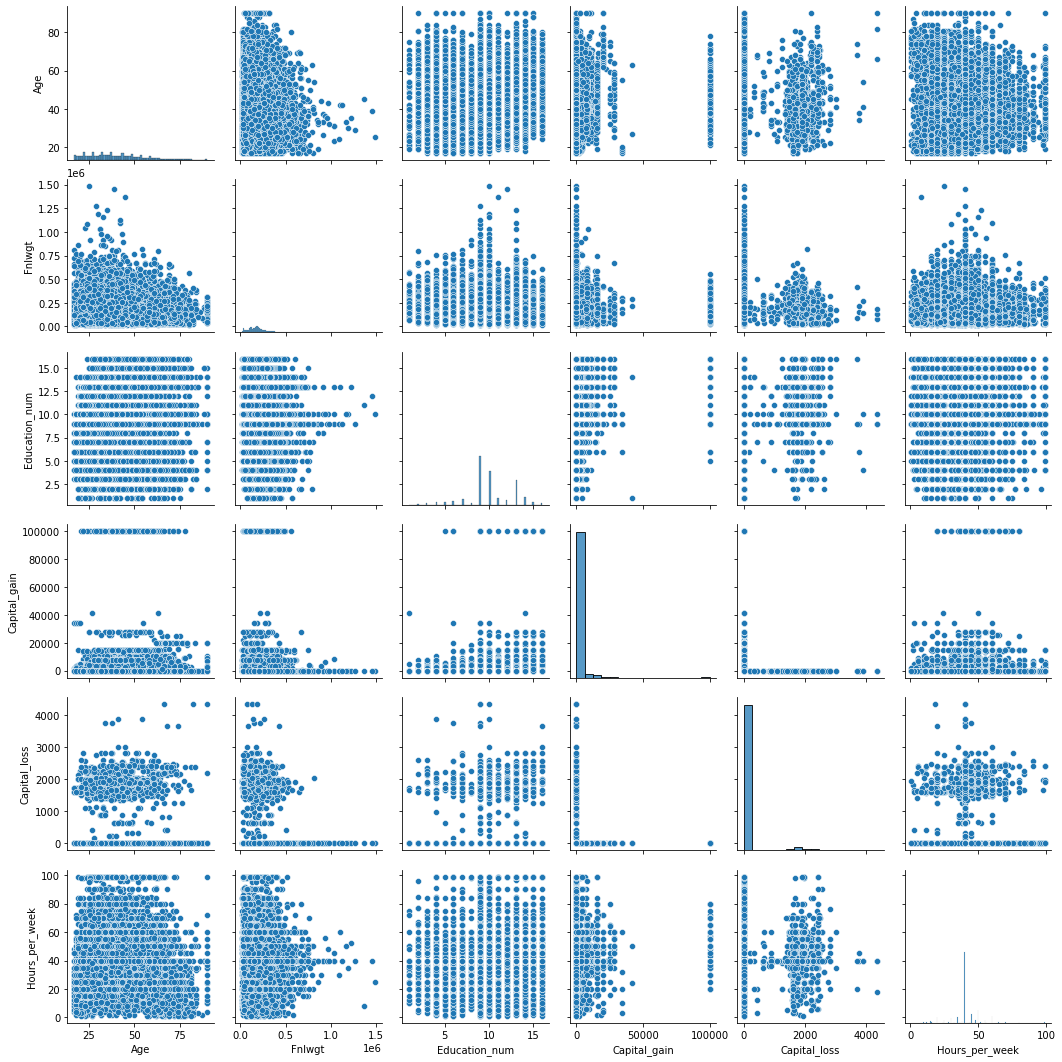

In [38]:
plt.figure(figsize=(15,15))
sns.pairplot(df)
plt.show()

#### People who are married are seen working than those not working, and most of working personel are males.
#### The average percent of people working who earn >50k are less than <50K.

### There is no much linearity observed in these above graphs. There can be no much inference from the above graphs

## Let us proceed with cleaning and preprocessing the data.

### Encoding:

In [39]:
#checking the datatypes
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

### There are 9 categorical attributes which need to be converted into numerical variables.
1. Let us replacing the unknown values present in attributes 'Native_country' with mode, and we see highest value in US, so converting all mapings into only 2 values US, Other.

In [40]:
df['Native_country'].value_counts()

 United-States                 29169
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [41]:
df = df.drop(df[df['Native_country'] == ' ?'].index)

In [42]:
col = ['Mexico','Philippines', 'Germany','Canada','Puerto-Rico','El-Salvador','India','Cuba','England','Jamaica','South','China','Italy','Dominican-Republic','Vietnam','Guatemala','Japan','Poland','Columbia','Taiwan','Haiti','Iran','Portugal','Nicaragua','Peru','France','Greece','Ecuador','Ireland','Hong','Trinadad&Tobago','Cambodia','Laos','Thailand','Yugoslavia',' Outlying-US(Guam-USVI-etc)','Honduras','Hungary','Scotland','Holand-Netherlands']
df['Native_country']=df['Native_country'].replace(to_replace=col,value='Others', regex=True)

df['Native_country'].unique()

array([' United-States', ' Others', ' Outlying-US(Guam-USVI-etc)'],
      dtype=object)

### Replacing unknown values with mode values of the column,'Occupation', and dropping unknown  'Workplace', values and converting Education classes into sub classes.

In [43]:
df['Workclass'].value_counts()

df = df.drop(df[df['Workclass']==' ?'].index)

In [44]:
df['Education'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th'], dtype=object)

Let us make only few sub-classes from above columns:

Preschool, 1-10 - school, 10-12- highschool, Bachelors, Masters, Doctorate


In [45]:
df['Education']=df['Education'].replace(to_replace=[' Preschool',' 1st-4th', ' 5th-6th', ' 7th-8th',' 10th',' 9th'],value='School')
df['Education']=df['Education'].replace(to_replace=[ 'Some-college',' Assoc-acdm',' Assoc-voc'' 11th',' 12th',],value='High School')
df['Education']=df['Education'].replace(to_replace=[' HS-grad',' Bachelors', 'Prof-school',' Assoc-voc'],value='Degree')

In [46]:
print(df['Occupation'].unique())
df['Occupation'].mode()

[' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Adm-clerical' ' Sales' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' Craft-repair'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv' ' ?']


0     Prof-specialty
dtype: object

In [47]:
df['Occupation']=df['Occupation'].replace(to_replace=[' ?'],value=' Prof-specialty')

### Now we have removed all the unknown values in the dataset, making it ready to convert Categorical columns into Numerical Columns,
### Encoding all the object datatypes into Numerical datatypes

In [48]:
lab_en =LabelEncoder()
for i in df.columns:
    if df[i].dtypes == 'object':
        df[i] = lab_en.fit_transform(df[i])


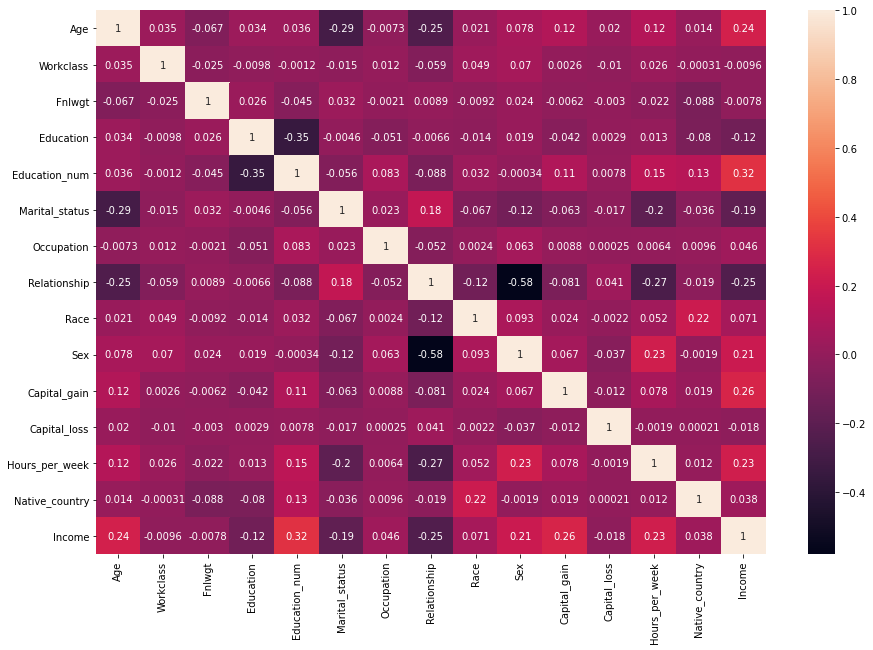

In [100]:
#checking the correlation of all the attributes

corr =df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True)
plt.show()

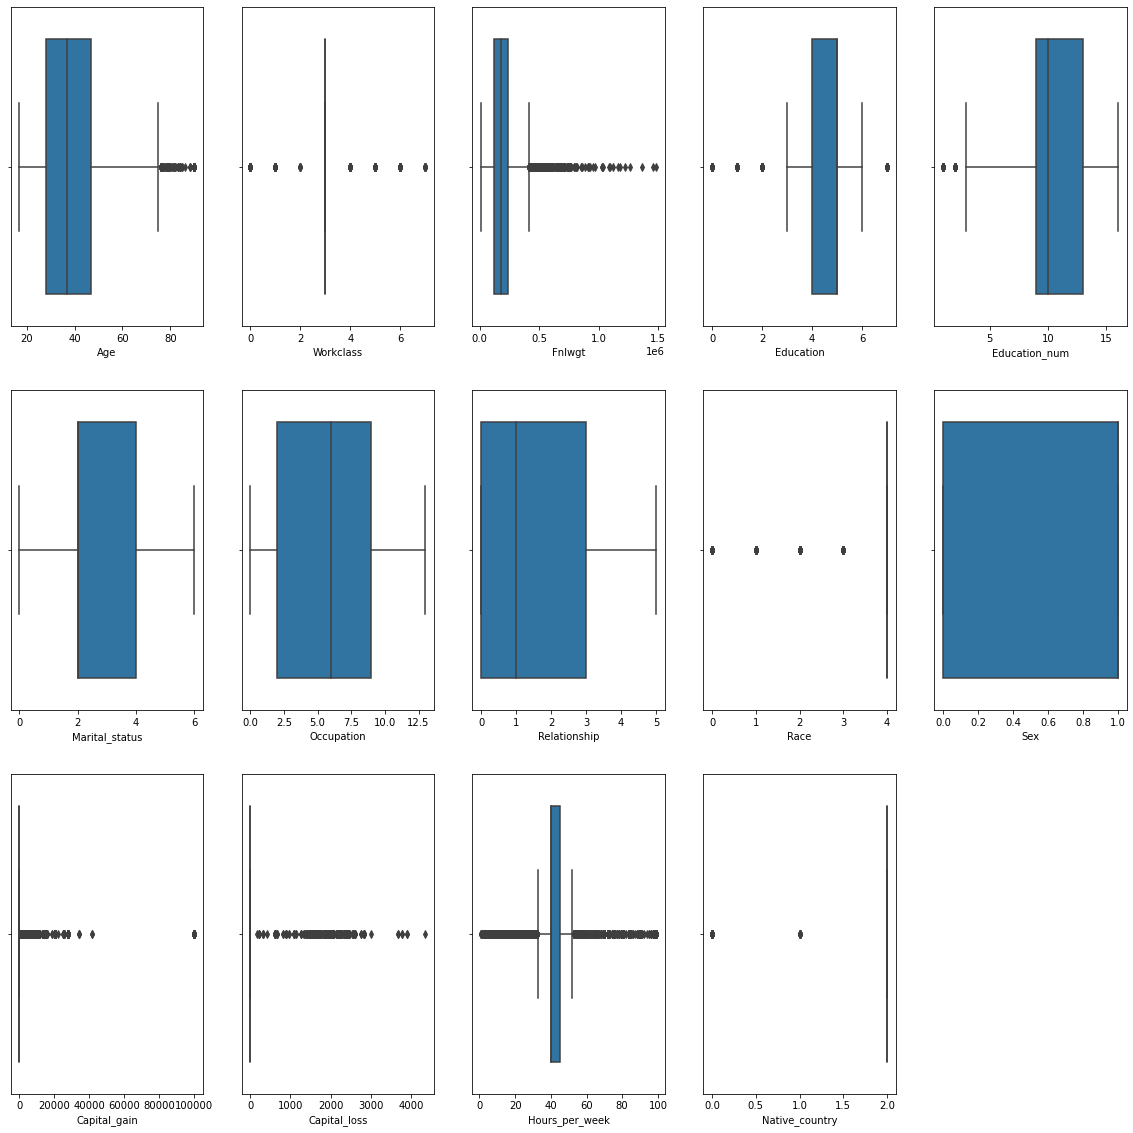

In [50]:
#checking the outliers present in all data set

plt.figure(figsize=(20,20))
pltno= 1
for i in df.columns:
    if pltno<15:
        ax = plt.subplot(3,5,pltno)
        sns.boxplot(df[i])
        plt.xlabel(i, fontsize=10)
        pltno+=1
plt.show()

There are outliers in Age, Fnlwgt, Capital Gain, Capital loss, Hours per week. These outliers need to be treated using z-score.

In [51]:
print("Before Outlier removal",df.shape)
z_score = zscore(df[['Age','Fnlwgt','Capital_gain','Capital_loss','Hours_per_week']])
abs_zsc = np.abs(z_score)

df = df[(abs_zsc<3).all(axis=1)]

print("After Outlier removal",df.shape)

Before Outlier removal (30168, 15)
After Outlier removal (27802, 15)


In [52]:
#checking the skewness of the data and treating with some Transformation methods
df.skew()

Age                0.447156
Workclass          0.081160
Fnlwgt             0.629870
Education         -1.289352
Education_num     -0.317960
Marital_status    -0.042241
Occupation         0.115377
Relationship       0.777614
Race              -2.496527
Sex               -0.711327
Capital_gain       4.871872
Capital_loss      29.100895
Hours_per_week    -0.281283
Native_country    -2.898990
Income             1.286008
dtype: float64

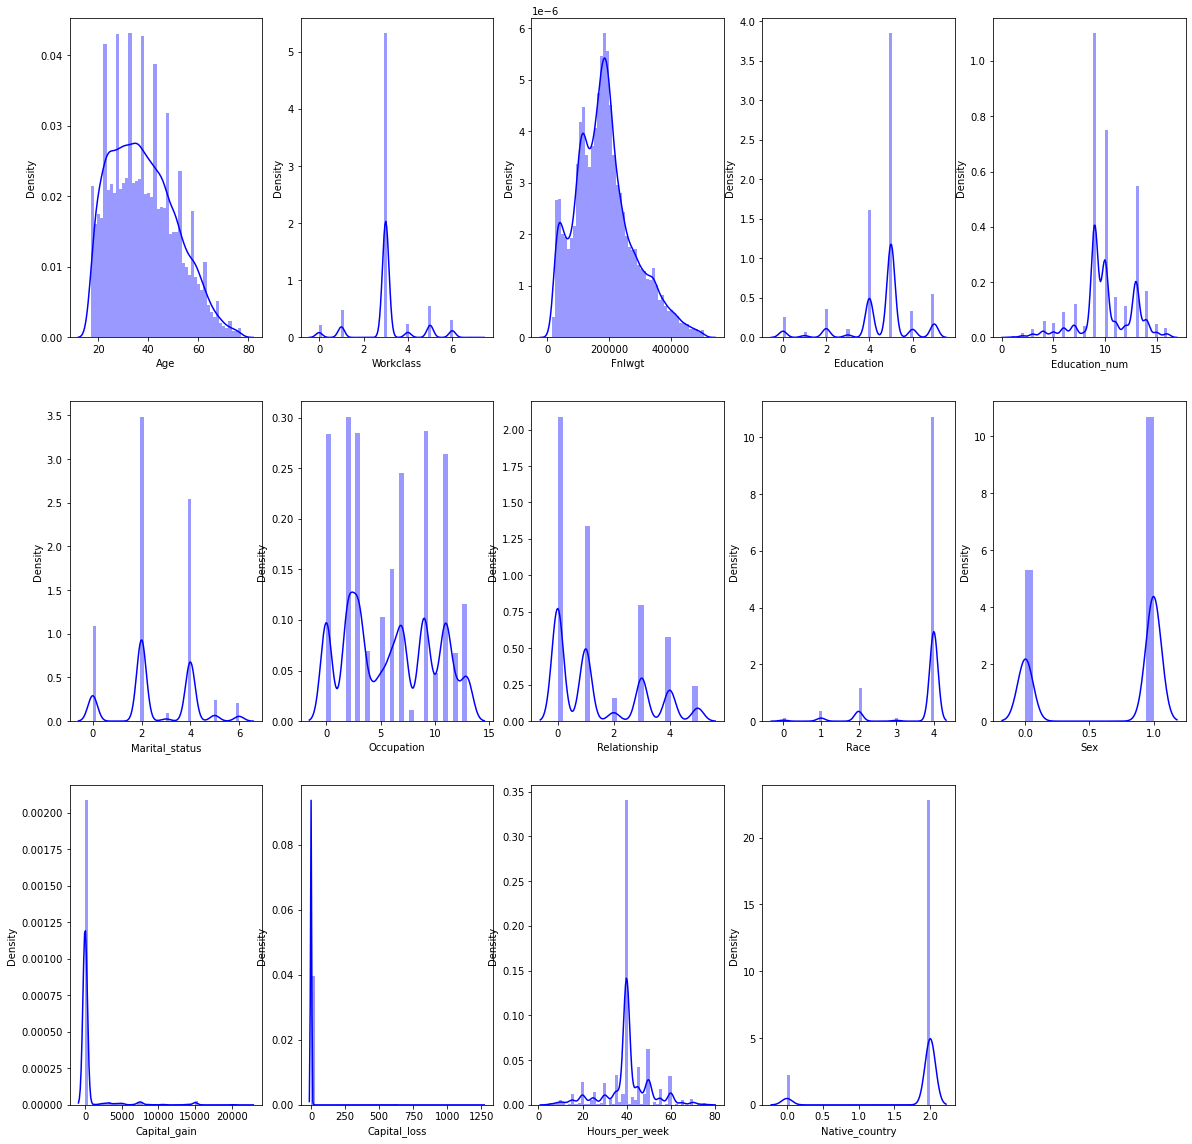

In [53]:
plt.figure(figsize=(20,20))
pltno= 1
for i in df.columns:
    if pltno<15:
        ax = plt.subplot(3,5,pltno)
        sns.distplot(df[i], color='blue')
        plt.xlabel(i, fontsize=10)
        pltno+=1
plt.show()

In [54]:
power_tfr = PowerTransformer()
col = ['Capital_gain','Capital_loss', 'Fnlwgt']

df[col] = power_tfr.fit_transform(df[col].values)

In [55]:
#re validating if the skewness in the dataset has been reduced

df.skew()

Age                0.447156
Workclass          0.081160
Fnlwgt            -0.035558
Education         -1.289352
Education_num     -0.317960
Marital_status    -0.042241
Occupation         0.115377
Relationship       0.777614
Race              -2.496527
Sex               -0.711327
Capital_gain       3.064517
Capital_loss      24.524638
Hours_per_week    -0.281283
Native_country    -2.898990
Income             1.286008
dtype: float64

## Model Building
### Standardization
Splitting the data set into Feature attributes and Target attribute.

As the dataset is not balanced, it need to be balanced before model building else it will impact the accuracy of data. Using SMOTE technique for Balancing the dataset.

In [57]:

X = df.drop(columns=['Income'])
y = df['Income']

scalar = StandardScaler()
X_scalar = scalar.fit_transform(X)


print("Before OverSampling, counts of label '1': {}".format(sum(y == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0)))

sm = SMOTE(random_state = 2)
X_scalar, y = sm.fit_resample(X_scalar, y.ravel())


print('After OverSampling, the shape of train_X: {}'.format(X_scalar.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y == 0)))

Before OverSampling, counts of label '1': 6383
Before OverSampling, counts of label '0': 21419 

After OverSampling, the shape of train_X: (42838, 14)
After OverSampling, the shape of train_y: (42838,) 

After OverSampling, counts of label '1': 21419
After OverSampling, counts of label '0': 21419


In [59]:
#Selecting best random state
max_acc = 0
max_RS = 0
i=1
for i in range(2, 200):
    models= [LogisticRegression()]
    X_train, X_test, y_train, y_test = train_test_split(X_scalar,y, test_size=0.3, random_state=i)
    for j in models:
        j.fit(X_train,y_train)
    predict = j.predict(X_test)
    acc = accuracy_score(y_test, predict)
    if acc>max_acc:
        max_acc = acc
        max_RS=i
        model = j
        i+=1
print('Max accuracy:',max_acc,'for',model ,'model and random state of', max_RS)

Max accuracy: 0.7706971677559913 for LogisticRegression() model and random state of 51


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_scalar, y, test_size =0.25, random_state=51)

## 1. Logistic Regression

In [72]:
Log_reg = LogisticRegression()
Log_reg.fit(X_train, y_train)
y_pred = Log_reg.predict(X_test)

print("******************RESULTS******************")
print("\n The accuracy score of Model :", accuracy_score(y_test,y_pred))
print("\n The ROC AUC score of Model :", roc_auc_score(y_test,y_pred))


CV=cross_val_score(Log_reg,X_train, y_train,cv=5)
print("\n The CV score of Model :", CV.mean())

print("\n The confusion Matrix :\n ", confusion_matrix(y_test, y_pred))
print("\n The classification report:\n ",classification_report(y_test, y_pred))

      
print("*******************************************")

******************RESULTS******************

 The accuracy score of Model : 0.7709617180205416

 The ROC AUC score of Model : 0.7709630004184684

 The CV score of Model : 0.7593061601640224

 The confusion Matrix :
  [[4125 1235]
 [1218 4132]]

 The classification report:
                precision    recall  f1-score   support

           0       0.77      0.77      0.77      5360
           1       0.77      0.77      0.77      5350

    accuracy                           0.77     10710
   macro avg       0.77      0.77      0.77     10710
weighted avg       0.77      0.77      0.77     10710

*******************************************


## 2. Random Forest Classifier

In [64]:
rand_for = RandomForestClassifier()
rand_for.fit(X_train, y_train)
y_pred = rand_for.predict(X_test)

print("******************RESULTS******************")
print("\n The accuracy score of Model :", accuracy_score(y_test,y_pred)) 
print("\n The ROC AUC score of Model :", roc_auc_score(y_test,y_pred))

CV=cross_val_score(rand_for,X_train, y_train,cv=5)
print("\n The CV score of Model :", CV.mean())

print("\n The confusion Matrix :\n ", confusion_matrix(y_test, y_pred))
print("\n The classification report:\n ",classification_report(y_test, y_pred))
      
      
print("*******************************************")

******************RESULTS******************

 The accuracy score of Model : 0.899906629318394

 The ROC AUC score of Model : 0.8999095062072813

 The CV score of Model : 0.8923992680513623

 The confusion Matrix :
  [[4807  553]
 [ 519 4831]]

 The classification report:
                precision    recall  f1-score   support

           0       0.90      0.90      0.90      5360
           1       0.90      0.90      0.90      5350

    accuracy                           0.90     10710
   macro avg       0.90      0.90      0.90     10710
weighted avg       0.90      0.90      0.90     10710

*******************************************


## 3. KNN Classifier

In [65]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

print("******************RESULTS******************")
print("\n The accuracy score of Model :", accuracy_score(y_test,y_pred)) 
print("\n The ROC AUC score of Model :", roc_auc_score(y_test,y_pred))

CV=cross_val_score(knn_clf,X_train, y_train,cv=5)
print("\n The CV score of Model :", CV.mean())

print("\n The confusion Matrix :\n ", confusion_matrix(y_test, y_pred))
print("\n The classification report:\n ",classification_report(y_test, y_pred))
      
      
print("*******************************************")

******************RESULTS******************

 The accuracy score of Model : 0.8550887021475256

 The ROC AUC score of Model : 0.8551591923559771

 The CV score of Model : 0.8396103669310353

 The confusion Matrix :
  [[4179 1181]
 [ 371 4979]]

 The classification report:
                precision    recall  f1-score   support

           0       0.92      0.78      0.84      5360
           1       0.81      0.93      0.87      5350

    accuracy                           0.86     10710
   macro avg       0.86      0.86      0.85     10710
weighted avg       0.86      0.86      0.85     10710

*******************************************


## 4. Decision Tree Classifier

In [66]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

print("******************RESULTS******************")
print("\n The accuracy score of Model :", accuracy_score(y_test,y_pred)) 
print("\n The ROC AUC score of Model :", roc_auc_score(y_test,y_pred))

CV=cross_val_score(dt_clf,X_train, y_train,cv=5)
print("\n The CV score of Model :", CV.mean())

print("\n The confusion Matrix :\n ", confusion_matrix(y_test, y_pred))
print("\n The classification report:\n ",classification_report(y_test, y_pred))
      
      
print("*******************************************")

******************RESULTS******************

 The accuracy score of Model : 0.8578898225957049

 The ROC AUC score of Model : 0.8578890012554051

 The CV score of Model : 0.8443725138996367

 The confusion Matrix :
  [[4603  757]
 [ 765 4585]]

 The classification report:
                precision    recall  f1-score   support

           0       0.86      0.86      0.86      5360
           1       0.86      0.86      0.86      5350

    accuracy                           0.86     10710
   macro avg       0.86      0.86      0.86     10710
weighted avg       0.86      0.86      0.86     10710

*******************************************


## 5. Gradient Boosting Classifier

In [67]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

print("******************RESULTS******************")
print("\n The accuracy score of Model :", accuracy_score(y_test,y_pred)) 
print("\n The ROC AUC score of Model :", roc_auc_score(y_test,y_pred))

CV=cross_val_score(gb_clf,X_train, y_train,cv=5)
print("\n The CV score of Model :", CV.mean())

print("\n The confusion Matrix :\n ", confusion_matrix(y_test, y_pred))
print("\n The classification report:\n ",classification_report(y_test, y_pred))
      
      
print("*******************************************")

******************RESULTS******************

 The accuracy score of Model : 0.8699346405228758

 The ROC AUC score of Model : 0.8699541428372157

 The CV score of Model : 0.8623008134511911

 The confusion Matrix :
  [[4551  809]
 [ 584 4766]]

 The classification report:
                precision    recall  f1-score   support

           0       0.89      0.85      0.87      5360
           1       0.85      0.89      0.87      5350

    accuracy                           0.87     10710
   macro avg       0.87      0.87      0.87     10710
weighted avg       0.87      0.87      0.87     10710

*******************************************


## 6. Support Vector Machine

In [83]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

print("******************RESULTS******************")
print("\n The accuracy score of Model :", accuracy_score(y_test,y_pred)) 
print("\n The ROC AUC score of Model :", roc_auc_score(y_test,y_pred))

CV=cross_val_score(svc_clf,X_train, y_train,cv=5)
print("\n The CV score of Model :", CV.mean())

print("\n The confusion Matrix :\n ", confusion_matrix(y_test, y_pred))
print("\n The classification report:\n ",classification_report(y_test, y_pred))
      
      
print("*******************************************")

******************RESULTS******************

 The accuracy score of Model : 0.830812324929972

 The ROC AUC score of Model : 0.8308700655600502

 The CV score of Model : 0.823518517307485

 The confusion Matrix :
  [[4122 1238]
 [ 574 4776]]

 The classification report:
                precision    recall  f1-score   support

           0       0.88      0.77      0.82      5360
           1       0.79      0.89      0.84      5350

    accuracy                           0.83     10710
   macro avg       0.84      0.83      0.83     10710
weighted avg       0.84      0.83      0.83     10710

*******************************************


#### Random Forest Classifier Model has the Highest CV score of 89.23% hence we are using this model to optimize parameters

## Hyperparameter Optimization

Let us tune some of the parameters of best model to improve the accuracy score of model

In [95]:
rand_clf = RandomForestClassifier()
params={'n_estimators' : [4,15 ],
            'max_depth':range(2,10),
            "min_samples_leaf":[1,6,9],
            'max_features':["auto","sqrt","log2"],
            }

grid_rf =GridSearchCV(rand_clf,param_grid=params)
grid_rf.fit(X_train,y_train) 
grid_rf.best_params_

{'max_depth': 9,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 15}

In [97]:
#reinstantiating model with best parameters
rand_clf = RandomForestClassifier(criterion='gini',n_estimators=15,max_features='log2',max_depth=9, min_samples_leaf=1)
rand_clf.fit(X_train,y_train)

y_pred = rand_clf.predict(X_test)

print("******************RESULTS******************")
print("\n The accuracy score of Model :", accuracy_score(y_test,y_pred))


CV=cross_val_score(rand_clf,X_train, y_train,cv=5)
print("\n The CV score of Model :", CV.mean())

print("\n The confusion Matrix :\n ", confusion_matrix(y_test, y_pred))
print("\n The classification report:\n ",classification_report(y_test, y_pred))
print("\n roc_auc_score: ",roc_auc_score(y_test,y_pred))
      
      
print("*******************************************")


******************RESULTS******************

 The accuracy score of Model : 0.8505135387488328

 The CV score of Model : 0.8433765163653011

 The confusion Matrix :
  [[4265 1095]
 [ 506 4844]]

 The classification report:
                precision    recall  f1-score   support

           0       0.89      0.80      0.84      5360
           1       0.82      0.91      0.86      5350

    accuracy                           0.85     10710
   macro avg       0.85      0.85      0.85     10710
weighted avg       0.85      0.85      0.85     10710


 roc_auc_score:  0.8505647579857721
*******************************************


<Figure size 1080x1080 with 0 Axes>

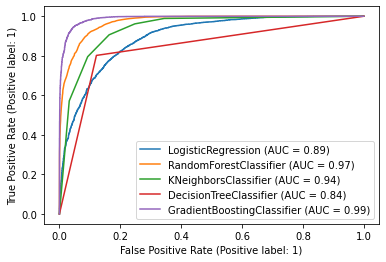

In [101]:
plt.figure(figsize=(15,15), facecolor='white')
show = plot_roc_curve(Log_reg,X_test, y_pred)
plot_roc_curve(rand_for,X_test, y_pred,ax=show.ax_)
plot_roc_curve(knn_clf,X_test, y_pred,ax=show.ax_)
plot_roc_curve(dt_clf,X_test, y_pred,ax=show.ax_)
plot_roc_curve(gb_clf,X_test, y_pred,ax=show.ax_) 

plt.show()

#### So the Model with best AUC is Gradient Boosting  followed by RandomForest Classifier. So Gradient Boosting is considered as BEST MODEL.

In [104]:
import pickle

file = open('Census Income Project.pkl', 'wb')
pickle.dump(gb_clf, file)